# Mass Univeriate

Use a multiple regression of the main experimental contrast, controlling for reaction time (you need to calculate RT yourself). 
* Example RQ: When/Where do we find differences between our conditions? Is there an influence of reaction time?
* different letters lead to a different signal?
* how does the response of high-performers differ from the response of low-performers?
* is it easier to have vocals or consonats as target, or often- vs not-so-often-used letters?

In [1]:
# general purpose
import numpy as np
import pandas as pd

# i/O
from scipy import io
from pathlib import Path
import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# testing
import unittest

# EEG stuff
import mne
import osfclient 
import mne_bids 
from mne_bids import (BIDSPath, read_raw_bids)

# EEG utils
import ccs_eeg_utils
import ccs_eeg_semesterproject

import configuration

- [Tutorial: Mass-univariate twoway repeated measures ANOVA on single trial power](https://mne.tools/stable/auto_tutorials/stats-sensor-space/70_cluster_rmANOVA_time_freq.html)
- [Linear Models Exercise](https://github.com/s-ccs/course_eeg_SS2022/blob/main/exercises/solutions/ex6_linearModels.ipynb)

In [4]:
subjects_df = pd.read_csv(configuration.path_subjects_df,delimiter=",",index_col=0)

subjects_df.head()

,subject_id,accuracy,trial_accuracy,channel,no_trials,avg_peak_latency,avg_peak_amplitude,condition,avg_response_time,mean_amplitude
0,27,89.0,67.500,Pz,200,0.337281,0.000013,target,0.351604,0.000008
1,27,89.0,94.375,Pz,200,0.337281,0.000010,distractor,0.304072,0.000005
2,4,95.0,75.000,Pz,200,0.317750,0.000018,target,0.308910,0.000016
3,4,95.0,100.000,Pz,200,0.329469,0.000012,distractor,0.267573,0.000010
4,22,91.5,67.500,Pz,200,0.446656,0.000017,target,0.406444,0.000014


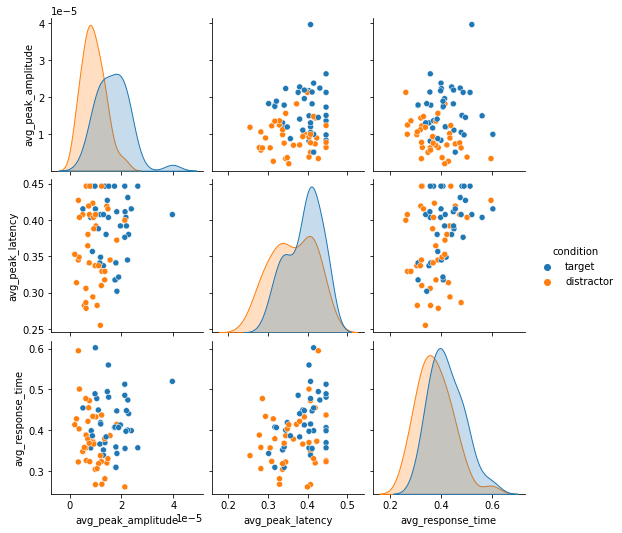

In [5]:
# is it correctly loaded?
sns.pairplot(subjects_df, vars=['avg_peak_amplitude','avg_peak_latency','avg_response_time'],
            diag_kind='kde',
            hue='condition')

I want to look into more details for the response time:

<AxesSubplot:xlabel='condition', ylabel='avg_response_time'>

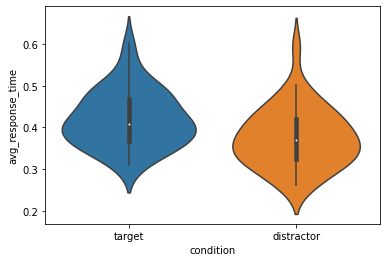

In [7]:
sns.violinplot(data=subjects_df, x='condition', y='avg_response_time')

(Perfect, now it works again...)

## regression: difference btw conditions based on evoked data

I want to predict the condition based on the features I have at the moment in my dataframe and see which weight is the highest, i.e. which feature is most important to predict the condition:
$cond ~ \alpha + \beta_0 * \text{trial accuracy} + \beta_1 * \text{avg peak latency} + \beta_2 * \text{avg peak amplitude} + \beta_3 * \text{avg response time} + \beta_4 * \text{mean amplitude}$

In [6]:
# dummy encoding
cond = 1.*(subjects_df['condition'].values == 'target') # 1 = target

# normalization to [0, 1]
trial_acc = subjects_df['trial_accuracy'] / 100
peak_lat = subjects_df['avg_peak_latency'] / subjects_df['avg_peak_latency'].max()
resp = subjects_df['avg_response_time'] / subjects_df['avg_response_time'].max()
ampl = subjects_df['mean_amplitude'] / subjects_df['mean_amplitude'].max()